In [1]:
import pandas as pd
import numpy as np

In [2]:
with open('./data/RA_SU22_screen/RA_data.csv', 'r', encoding='utf-8-sig') as f: # because of the BOM and excel is stupid
# read in CSV files from data folder as a nunpy array
    data_np = np.genfromtxt(f, delimiter=',', dtype='int')
with open('./data/RA_SU22_screen/RA_labels.csv', 'r', encoding='utf-8-sig') as f: # because of the BOM and excel is stupid
# read in labels of the data
    labels_np = np.genfromtxt(f, delimiter=',', dtype='str')

# peptide 86 is the even rows
pep86 = data_np[::2]
# peptide 104 is the odd rows
pep104 = data_np[1::2]

# same with labels
pep86_labels = labels_np[::2]
pep104_labels = labels_np[1::2]

# reshape them all into a single column
pep86 = pep86.reshape(-1,1)
pep104 = pep104.reshape(-1,1)
pep86_labels = pep86_labels.reshape(-1,1)
pep104_labels = pep104_labels.reshape(-1,1)


# # reshape both into a single column
# data_np = data_np.reshape(-1,1)
# labels_np = labels_np.reshape(-1,1)

# # peptide 86 are the first 12 lines
# pep86 = data_np[::2]
# # peptide 104 are the second 12 lines
# pep104 = data_np[1::2]

# # same with labels
# pep86_labels = labels_np[::2]
# pep104_labels = labels_np[1::2]

pep104[:24]


array([[66078],
       [52239],
       [56019],
       [14700],
       [75820],
       [ 6280],
       [44428],
       [39044],
       [  849],
       [    9],
       [ 6378],
       [ 7925],
       [27989],
       [ 2039],
       [40773],
       [15483],
       [    7],
       [49305],
       [    7],
       [    7],
       [   10],
       [38578],
       [10131],
       [32766]])

In [3]:
# create a dataframe with the data and labels
df = pd.DataFrame(data=np.concatenate((pep86,pep104), axis=1), columns=['86', '104'])
df['condition'] = pep86_labels # we only need this once
# when the condition columns is neither 'positive' or 'negative' it is 'experimental'
df['condition'] = df['condition'].apply(lambda x: 'experimental' if x not in ['positive', 'negative'] else x)
df['plate_number'] = np.concatenate((
    [np.repeat(x, 96) for x in range(1,len(df)//96+1)]
    ))

# make a list of 96 well plate labels with rows A-H and columns 1-12
plate_rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
plate_cols = [str(x) for x in range(1,13)]

# add two new columns to the dataframe for the well labels
df['row'] = np.tile(np.repeat(plate_rows, 12), len(df)//96)
df['column'] = np.tile(plate_cols, len(df)//12)


df[:24]

,86,104,condition,plate_number,row,column
0,81717,66078,positive,1,A,1
1,125233,52239,positive,1,A,2
2,114981,56019,positive,1,A,3
3,194017,14700,experimental,1,A,4
4,171267,75820,experimental,1,A,5
5,188569,6280,experimental,1,A,6
6,195035,44428,experimental,1,A,7
7,208453,39044,experimental,1,A,8
8,94460,849,experimental,1,A,9
9,21,9,experimental,1,A,10


In [51]:
def computeRatios(pivoted_data, pep0, pep1):
    """
    computes two ratios between respective peptides and adds two columns.
    """
    pep0 = pivoted_data[pep0]
    pep1 = pivoted_data[pep1]

    ratio0 = pep0 / pep1
    ratio1 = pep1 / pep0

    log0 = np.log10(ratio0)
    log1 = np.log10(ratio1)

    ratios_data = pivoted_data.copy()

    ratios_data[str(pep0.name) + "/" + str(pep1.name)] = log0
    ratios_data[str(pep1.name) + "/" + str(pep0.name)] = log1

    return ratios_data

def find_hits(
    data,
    stdev_threshold_brightness,
    stdev_threshold_selectivity_0,
    stdev_threshold_selectivity_1,
    pep0,
    pep1,
):
    """
    Finds hits and labels data based on the mean and stdev of the positive controls.
    """
    ratiostr0 = str(pep0) + "/" + str(pep1)
    ratiostr1 = str(pep1) + "/" + str(pep0)

    pos = data[data["condition"] == "positive"]

    mean0 = np.mean(pos[pep0])
    stdev0 = np.std(pos[pep0])
    mean_ratio0 = np.mean(pos[ratiostr0])
    stdev_ratio0 = np.std(pos[ratiostr0])

    mean1 = np.mean(pos[pep1])
    stdev1 = np.std(pos[pep1])
    mean_ratio1 = np.mean(pos[ratiostr1])
    stdev_ratio1 = np.std(pos[ratiostr1])

    hits = []

    for i, row in data.iterrows():
        # check if control
        if row["condition"] != "experimental":
            hits.append(row["condition"])
        # check for pep0 success
        elif (row[pep0] > stdev_threshold_brightness * stdev0 + mean0) and (
            row[ratiostr0]
            > stdev_threshold_selectivity_0 * stdev_ratio0 + mean_ratio0
        ):
            hits.append(pep0)
        elif (row[pep1] > stdev_threshold_brightness * stdev1 + mean1) and (
            row[ratiostr1]
            > stdev_threshold_selectivity_1 * stdev_ratio1 + mean_ratio1
        ):
            hits.append(pep1)
        else:
            hits.append("not significant")

    return data.assign(to_pick=hits)


def find_hits_by_plate(
    data,
    stdev_threshold_brightness,
    stdev_threshold_selectivity_0,
    stdev_threshold_selectivity_1,
    pep0,
    pep1
):
    """
    Finds hits using only the WT wells on the corresponding plate where the hit resides.
    """
    hitlist = []
    for platenum in set(data["plate_number"]):
        plate = data[data["plate_number"] == platenum]
        plate_hits = find_hits(
            plate,
            stdev_threshold_brightness,
            stdev_threshold_selectivity_0,
            stdev_threshold_selectivity_1,
            pep0,
            pep1,
        )
        hitlist.append(plate_hits)

    return pd.concat(hitlist)

import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance(data, peptide0, peptide1):

    fig = plt.figure(figsize=(10, 10))
    peptide0 = str(peptide0)
    peptide1 = str(peptide1)
    ratiostr = peptide0 + "/" + peptide1

    sns.scatterplot(x=peptide0, y=ratiostr, data=data, hue="to_pick")

In [52]:
df_c = computeRatios(df, '86', '104')
df_hits = find_hits_by_plate(df_c, -1, 2, 1, '86', '104')

df_hits

/Users/rathbunc/opt/anaconda3/envs/general-ml/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


,86,104,condition,plate_number,row,column,86/104,104/86,to_pick
0,81717,66078,positive,1,A,1,0.092256,-0.092256,positive
1,125233,52239,positive,1,A,2,0.379724,-0.379724,positive
2,114981,56019,positive,1,A,3,0.312291,-0.312291,positive
3,194017,14700,experimental,1,A,4,1.120522,-1.120522,not significant
4,171267,75820,experimental,1,A,5,0.353890,-0.353890,not significant
...,...,...,...,...,...,...,...,...,...
2011,476770,16221,experimental,21,H,8,1.468231,-1.468231,86
2012,560766,57023,experimental,21,H,9,0.992732,-0.992732,104
2013,521052,68323,experimental,21,H,10,0.882314,-0.882314,104
2014,455153,18419,experimental,21,H,11,1.392891,-1.392891,86


In [53]:
# find where 'to_pick' is '86' or '104' and count the number of times for each
df_hits[df_hits['to_pick'].isin(['86', '104'])].groupby('to_pick').count()['condition']

to_pick
104    206
86     267
Name: condition, dtype: int64

In [57]:
# find where 'to_pick' is '86' or '104' and count the number of times for each plate
df_hits[df_hits['to_pick'].isin(['86','104'])].groupby(['plate_number']).count()['condition']

plate_number
1     11
2     33
3     26
4     35
5     21
6     46
7     10
8     25
9     12
10    32
11    28
12    11
13    15
14    33
15    12
16    14
17     7
18    14
19    24
20    25
21    39
Name: condition, dtype: int64

/Users/rathbunc/opt/anaconda3/envs/general-ml/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10


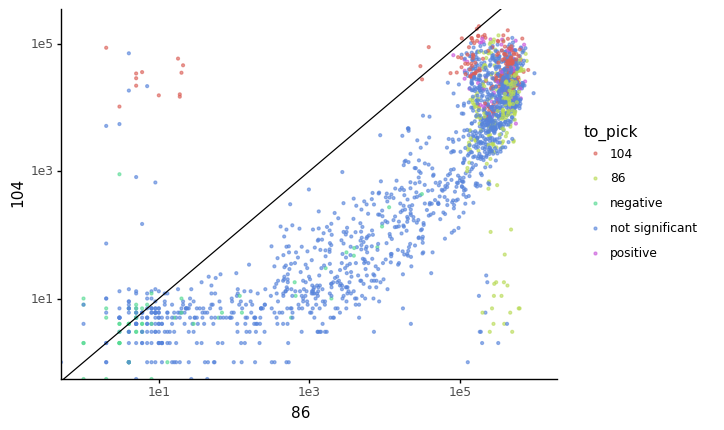

<ggplot: (8791438758653)>

In [55]:
import plotnine as pn

(
    pn.ggplot(
        df_hits,
        pn.aes(df_hits["86"], df_hits["104"], color="to_pick"),
    )
    + pn.geom_point(alpha=.6, size=0.7)
    + pn.scale_x_log10()
    + pn.scale_y_log10()
    + pn.geom_abline(intercept=0, slope=1)
    + pn.theme_classic() 
)

In [56]:
# export df_hits to csv with columns 'to_pick', 'plate_number', 'row', 'column' in that order
for_cherrypicking = df_hits[df_hits['to_pick'].isin(['86','104'])]
for_cherrypicking[['to_pick', 'plate_number', 'row', 'column']].to_csv('RA_2022.csv', index=True)